In [2]:
import warnings
warnings.filterwarnings("ignore")
from evaluation.mol_structure import list_of_smiles_to_nx_graphs,list_of_nx_graphs_to_smiles
from evaluation.mol_structure import draw_one_mol, draw_graphs
from evaluation.new_structural_metric import symmetric_graph_set_distance,atom,cycle,neighborhood
from evaluate import evaluate
#import utils.graph_generators as gen
import torch
import networkx as nx
import os 
import sys
import json
current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
import rdkit
import numpy as np
from evaluation.utils import get_data,  get_mock_data,remove_empty_graphs_and_targets,\
    get_generated_data,preprocess,get_graph_data, get_generated_graph_data
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import ChiralType, BondType, BondDir
from rdkit.Chem.rdmolops import AddHs
from evaluation.atom_bond_encoder import  atom_to_feature_vector,bond_to_feature_vector
from evaluation.moses.metrics.metrics import get_all_metrics



#  Functions used

The standard converters from  nx and rdkit 

In [120]:
def rdkmol_to_nx(mol):
    #  rdkit-mol object to nx.graph
    graph = nx.Graph()
    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(), label=int(atom.GetAtomicNum()), attr=atom_to_feature_vector(atom) ,  label_name=atom.GetSymbol())
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(),label=(int(bond.GetBondTypeAsDouble())),
                       attr=bond_to_feature_vector(bond),
                       edge_label=str(bond.GetBondType()) )
    return graph

def smiles_to_mol(list_of_smiles):
    list_of_rdkit_mols=[]
    for _,smile in enumerate(list_of_smiles):
        try:
            mol = Chem.MolFromSmiles(smile)
            list_of_rdkit_mols.append(mol)
        except:list_of_rdkit_mols.append(Chem.MolFromSmiles('C'))
    return list_of_rdkit_mols
    



def nx_to_rdkit(graph):
    m = Chem.MolFromSmiles('')
    mw = Chem.RWMol(m)
    atom_index = {}
    for n, d in graph.nodes(data=True):
        atom_index[n] = mw.AddAtom(Chem.Atom(d['label']))
    for a, b, d in graph.edges(data=True):
        start = atom_index[a]
        end = atom_index[b] 
        bond_type=d['edge_label']
        try:
            mw.AddBond(start, end, eval("rdkit.Chem.rdchem.BondType.{}".format(bond_type)))
        except:
            mw.AddBond(start, end, eval("rdkit.Chem.rdchem.BondType.{}".format('SINGLE')))
            #print('exc',bond_type)
            continue
            raise Exception('bond type not implemented')

    mol = mw.GetMol()
    return mol

def list_of_smiles_to_nx_graphs(smiles):
    list_of_nx_graphs=[]
    for i,smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
           list_of_nx_graphs.append(rdkmol_to_nx(mol))
        else:
            continue
         
    return list_of_nx_graphs


def list_of_nx_graphs_to_smiles(graphs, file=None):
    # writes smiles strings to a file
    chem = [nx_to_rdkit(graph) for graph in graphs]
    smis = [Chem.MolToSmiles(m) for m in chem]
    if file:
        with open(file, 'w') as f:
            f.write('\n'.join(smis))
    return smis


# Smiles =>  Molecular graphs =>  Smiles

# Train1 vs Train1                    /Before vs After graph conversion of the train smiles using directly the get_all_metrics from moses


I am trying to compare sets of training smiles  against sets of training smiles and evaluate those using Moses.
As we can see bellow, initially the evaluation fails for the graphs converted back to smiles. 

In [73]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_50']
device=torch.device('cpu')
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']#'common_substructures']

metrics_type=['molecular']
#leave it blank to compute all the structural structures 
metrics={}
metrics2={}
for generator in ['train1']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
                print(dataset_name+split, generator)
                graphs,smiles  =get_data(dataset_name+split, return_smiles=True)
                train1_smiles_before_conversion=smiles['train1_pos_smiles']+ smiles['train1_neg_smiles']
                train1_graphs=list_of_smiles_to_nx_graphs(train1_smiles_before_conversion)
                train1_smiles=list_of_nx_graphs_to_smiles(train1_graphs)          
                print('Metrics before  coversion:')
                metrics=get_all_metrics(gen=train1_smiles_before_conversion,train=train1_smiles_before_conversion,test=train1_smiles_before_conversion)
                print(metrics)
                print('Metrics after  coversion:')
                try:
                    metrics2=get_all_metrics(gen=train1_smiles,train=train1_smiles,test=train1_smiles)
                    print(metrics2)
                except:
                    print('Error when computing the metrics for the converted graphs')
                    continue
                

ames_50 train1
Metrics before  coversion:
{'valid': 1.0, 'unique@1000': 0.999, 'unique@10000': 0.9996073812328229, 'FCD/Test': -3.552713678800501e-13, 'SNN/Test': 1.0, 'Frag/Test': 1, 'Scaf/Test': 1, 'FCD/TestSF': 22.270570164551017, 'SNN/TestSF': 0.33544746274439363, 'Frag/TestSF': -0.06553137100764106, 'Scaf/TestSF': 0.13905682249091533, 'IntDiv': 0.9105206593714188, 'IntDiv2': 0.8919648544524341, 'Filters': 0.5551629367883785, 'logP': 0.0, 'SA': 0.0, 'QED': 0.0, 'weight': 0.0, 'Novelty': 0.0015710919088766694}
Metrics after  coversion:
Error when computing the metrics for the converted graphs
bbb_martins_50 train1
Metrics before  coversion:
{'valid': 1.0, 'unique@1000': 0.9943661971830986, 'unique@10000': 0.9943661971830986, 'FCD/Test': -5.826450433232822e-13, 'SNN/Test': 1.0, 'Frag/Test': 1, 'Scaf/Test': 1, 'FCD/TestSF': 19.4438681661209, 'SNN/TestSF': 0.3730856233761764, 'Frag/TestSF': -0.10547896046759009, 'Scaf/TestSF': 0.024943099994351514, 'IntDiv': 0.8849596139292613, 'IntDiv

# Example of equivalent smiles that will raise an exception  during evaluation. Although the smiles are similar , we can notice  that the stereochemistry is lost which may be the reason for the error

So of course my first  step was trying to identify whether my converted  (smiles=>mols=>graphs=>mols=>smiles2 ) smiles2 contain any 'None; , null or empty strings or even 1-atom smiles strings which was not the case. So I manuually tried to see which smiles, (otherwise valid ones) would cause erors. For example, here I discovered after testing that smile at location 14 from the cyp1a2_veith_50  dataset will  generate an evaluation error: 

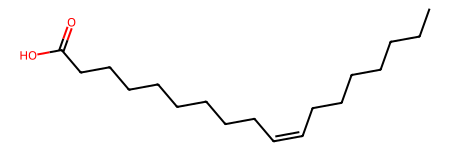

In [84]:
smiles_to_mol([train1_smiles_before_conversion[14]])[0]

In [66]:
train1_smiles_before_conversion[14]

'CCCCCCC/C=C\\CCCCCCCCC(=O)O'

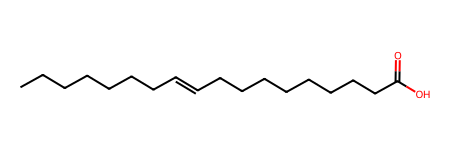

In [59]:
#The smile after conversion, respecting teh  number of edges and atoms but withj removed stereochemistry
smiles_to_mol([train1_smiles[14]])[0]

In [85]:
train1_smiles[14]

'CCCCCCCC=CCCCCCCCCC(=O)O'

In [67]:
get_all_metrics(gen=train1_smiles_before_conversion[:14],train=train1_smiles_before_conversion[:14],test=train1_smiles_before_conversion[:14])

{'valid': 1.0,
 'unique@1000': 1.0,
 'unique@10000': 1.0,
 'FCD/Test': nan,
 'SNN/Test': 1.0,
 'Frag/Test': 1,
 'Scaf/Test': 1,
 'FCD/TestSF': nan,
 'SNN/TestSF': 0.45974692915167126,
 'Frag/TestSF': 0.20737029122517026,
 'Scaf/TestSF': 0.0,
 'IntDiv': 0.7967902275980735,
 'IntDiv2': 0.6934234527593401,
 'Filters': 0.8571428571428571,
 'logP': 0.0,
 'SA': 0.0,
 'QED': 0.0,
 'weight': 0.0,
 'Novelty': 0.0}

In [68]:

get_all_metrics(gen=train1_smiles[:14],train=train1_smiles[:14],test=train1_smiles[:14])

ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcCrippenDescriptors(NoneType)
did not match C++ signature:
    CalcCrippenDescriptors(class RDKit::ROMol mol, bool includeHs=True, bool force=False)

# FIX- Preserve stereochemistry when converting the smiles to graphs and the graphs back from smiles by making some properties more explicit 

Adapted from: 
https://github.com/dakoner/keras-molecules/blob/dbbb790e74e406faa70b13e8be8104d9e938eba2/convert_rdkit_to_networkx.py#L17

In [3]:
def rdkmol_to_nx(mol):
    #  rdkit-mol object to nx.graph
    graph = nx.Graph()
    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(), label=int(atom.GetAtomicNum()), attr=atom_to_feature_vector(atom) ,  label_name=atom.GetSymbol(),
                   atomic_num=atom.GetAtomicNum(),
                   formal_charge=atom.GetFormalCharge(),
                   chiral_tag=atom.GetChiralTag(),
                   hybridization=atom.GetHybridization(),
                   num_explicit_hs=atom.GetNumExplicitHs(),
                   is_aromatic=atom.GetIsAromatic()) 
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(),label=(int(bond.GetBondTypeAsDouble())),
                       attr=bond_to_feature_vector(bond),
                       edge_label=str(bond.GetBondType()),
                       bond_type= bond.GetBondType())
    return graph

def smiles_to_mol(list_of_smiles):
    list_of_rdkit_mols=[]
    for _,smile in enumerate(list_of_smiles):
        try:
            mol = Chem.MolFromSmiles(smile)
            list_of_rdkit_mols.append(mol)
        except:list_of_rdkit_mols.append(Chem.MolFromSmiles('C'))
    return list_of_rdkit_mols
    



def nx_to_rdkit(graph):
    m = Chem.MolFromSmiles('')
    atomic_nums = nx.get_node_attributes(graph, 'atomic_num')
    chiral_tags = nx.get_node_attributes(graph, 'chiral_tag')
    formal_charges = nx.get_node_attributes(graph, 'formal_charge')
    node_is_aromatics = nx.get_node_attributes(graph, 'is_aromatic')
    node_hybridizations = nx.get_node_attributes(graph, 'hybridization')
    num_explicit_hss = nx.get_node_attributes(graph, 'num_explicit_hs')
    mw = Chem.RWMol(m)
    node_to_idx = {}
    for node in graph.nodes():
        a=Chem.Atom(atomic_nums[node])
        a.SetChiralTag(chiral_tags[node])
        a.SetFormalCharge(formal_charges[node])
        a.SetIsAromatic(node_is_aromatics[node])
        a.SetHybridization(node_hybridizations[node])
        a.SetNumExplicitHs(num_explicit_hss[node])
        idx = mw.AddAtom(a)
        node_to_idx[node] = idx

    bond_types = nx.get_edge_attributes(graph, 'bond_type')
    for a, b, d in graph.edges(data=True):
        start = node_to_idx[a]
        end = node_to_idx[b] 
        bond_type=bond_types[a,b]
        try:
            mw.AddBond(start, end, bond_type)
        except:
            mw.AddBond(start, end, eval("rdkit.Chem.rdchem.BondType.{}".format('SINGLE')))
            #print('exc',bond_type)
            continue
            raise Exception('bond type not implemented')

    Chem.SanitizeMol(mw)
    return mw

def list_of_smiles_to_nx_graphs(smiles):
    list_of_nx_graphs=[]
    for i,smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
           list_of_nx_graphs.append(rdkmol_to_nx(mol))
        else:
            continue
         
    return list_of_nx_graphs


def list_of_nx_graphs_to_smiles(graphs, file=None):
    # writes smiles strings to a file
    chem = [nx_to_rdkit(graph) for graph in graphs]
    smis = [Chem.MolToSmiles(m) for m in chem]
    if file:
        with open(file, 'w') as f:
            f.write('\n'.join(smis))
    return smis




In [4]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_50']
device=torch.device('cpu')
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']#'common_substructures']

metrics_type=['molecular']
#leave it blank to compute all the structural structures 
metrics={}
metrics2={}
for generator in ['train1']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
                print(dataset_name+split, generator)
                graphs,smiles  =get_data(dataset_name+split, return_smiles=True)
                train1_smiles_before_conversion=smiles['train1_pos_smiles']+ smiles['train1_neg_smiles']
                train1_graphs=list_of_smiles_to_nx_graphs(train1_smiles_before_conversion)
                train1_smiles=list_of_nx_graphs_to_smiles(train1_graphs)          
                print('Metrics before  coversion:')
                metrics=get_all_metrics(gen=train1_smiles_before_conversion,train=train1_smiles_before_conversion,test=train1_smiles_before_conversion)
                print(metrics)
                print('Metrics after  coversion:')
                try:
                    metrics2=get_all_metrics(gen=train1_smiles,train=train1_smiles,test=train1_smiles)
                    print(metrics2)
                except:
                    print('Error when computing the metrics for the converted graphs')
                    continue

ames_50 train1
Metrics before  coversion:
{'valid': 1.0, 'unique@1000': 0.999, 'unique@10000': 0.9996073812328229, 'FCD/Test': -3.552713678800501e-13, 'SNN/Test': 1.0, 'Frag/Test': 1, 'Scaf/Test': 1, 'FCD/TestSF': 22.270570164551017, 'SNN/TestSF': 0.33544746274439363, 'Frag/TestSF': -0.06553137100764106, 'Scaf/TestSF': 0.13905682249091533, 'IntDiv': 0.9105206593714188, 'IntDiv2': 0.8919648544524341, 'Filters': 0.5551629367883785, 'logP': 0.0, 'SA': 0.0, 'QED': 0.0, 'weight': 0.0, 'Novelty': 0.0015710919088766694}
Metrics after  coversion:
{'valid': 1.0, 'unique@1000': 0.999, 'unique@10000': 0.9996073812328229, 'FCD/Test': 2.2026824808563106e-13, 'SNN/Test': 1.0, 'Frag/Test': 1, 'Scaf/Test': 1, 'FCD/TestSF': 22.271112528170434, 'SNN/TestSF': 0.33544746274439363, 'Frag/TestSF': -0.06551872571011819, 'Scaf/TestSF': 0.1385673996879525, 'IntDiv': 0.9105226033883607, 'IntDiv2': 0.8919665588930472, 'Filters': 0.5551629367883785, 'logP': 0.0, 'SA': 0.0, 'QED': 0.0, 'weight': 0.0, 'Novelty': 0.

Although,  making some molecular  properties more explicit, would solve the errors , I still found some variability in  the  converted data as it is the case for herg_karim_50. See: 'logP': 7.549327834255075e-19, 'SA': 0.0, 'QED': 1.1795824741022784e-20, 'weight': 4.8315698139235636e-17 which were epected to be eequal to 0. 
Conclusion:  always use the original smiles in your molecular  evaluation and not their smi=>mol=>nx=>mol=>smi equivalent
